In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras import layers

In [4]:
# dataset url
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')             # path to downloaded dataset

train_dir = os.path.join(PATH, 'train')                                                 # train directory
validation_dir = os.path.join(PATH, 'validation')                                       # validation directory

BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)                                                                 # 160x160 pixels

# training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE)

# validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


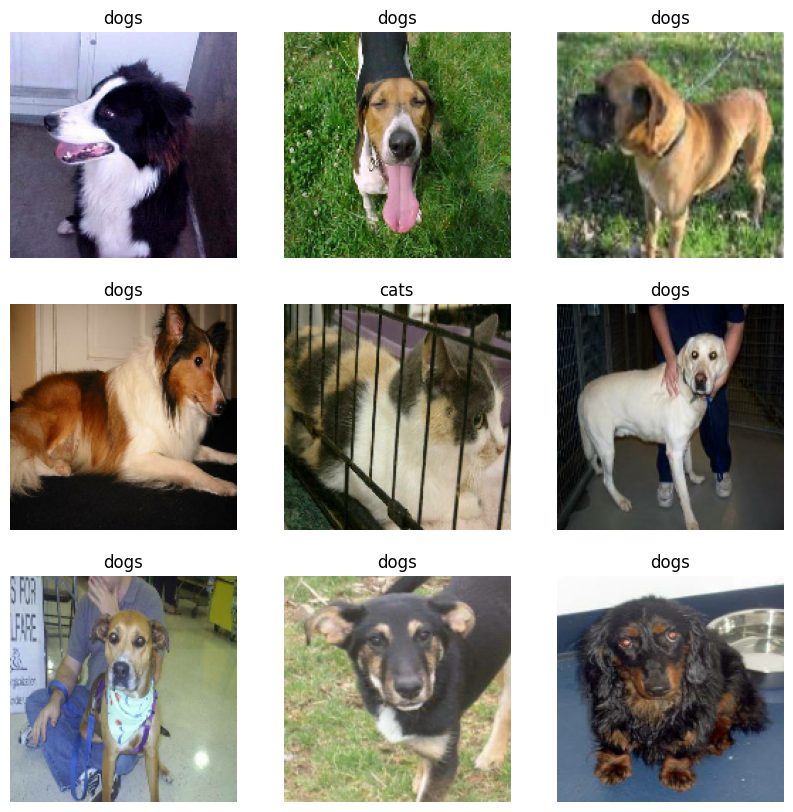

In [9]:
# classes from the dataset
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)                   # 3x3 grid of images
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
# creating a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))



# Optimizing dataset for better performance (prefetching helps yield data from disk without I/O blocking)
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Number of validation batches: 17
Number of test batches: 4


In [16]:
# Use data augmentation to better train the model (reduce overfitting and adapt model to images shifting)
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip('horizontal'),        # randomly flips
        layers.RandomRotation(0.2)              # randomly rotates
    ]
)

In [18]:
# We will use MobileNet V2 as the base model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = layers.Rescaling(1./127.5, offset=-1)

In [24]:
# The base model is made from MobileNet V2
# We need to pick a layer for feature extraction. Usually, the last layer before the flatten layer is used.
# This is because it has it has general, "bigger picture" features than lower layers

# Create the base model from the pre-trained model MobileNet V2
IMAGE_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=False,           # excludes the "topmost" layer, ie. one before flatten layer
                                               weights='imagenet')

# The feature extractor layer converts images to a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [25]:
# We then need to freeze the "convolutional base" so that the model keeps its weights and we only train the layer that we will add
base_model.trainable = False

# Many models contain the "BatchNormalization" layer(s)
# When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode
# by passing training = False when calling base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [27]:
# This generates predictions from the block of features
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Single Dense layer to convert features into a prediction. Prediciton will be treated as a logit (ie. 1 for True and 0 for False)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


In [29]:
# Actually building a model with data_augmentation, rescaling, base_model, and featyure extraction layers
inputs = tf.keras.Input(shape=(160, 160, 3))            # specifies input dimensions
x = data_augmentation(inputs)                           # gives data_augmentation layers the input dimensions
x = preprocess_input(x)                                 # preprocess input with data_augmentation layer
x = base_model(x, training=False)                       # data_augmentation and preprovessing gets added to base model, base layers aren't trained
x = global_average_layer(x)                             # 
x = tf.keras.layers.Dropout(0.2)(x)                     # dropout layers (20%) added to model
outputs = prediction_layer(x)                           # prediction layer uses all of above additions
model = tf.keras.Model(inputs, outputs)                 # model is made from input dimensions and all above additons

In [32]:
# learning_rate 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# show the model summary
# model.summary()

# 2257984 non-trainable parameters
# 1281 trainable parameters

In [33]:
# training epochs
initial_epochs = 10

# evaluate intial model (before training our layers) for accuracy and loss
loss0, accuracy0 = model.evaluate(validation_dataset)

17/17 [==============================] - 2s 77ms/step - loss: 0.6092 - accuracy: 0.5731


In [35]:
print("initial loss: {:.2f}".format(loss0))                 # ~0.61
print("initial accuracy: {:.2f}".format(accuracy0))         # ~0.57

initial loss: 0.61
initial accuracy: 0.57


In [37]:
# trains model for 10 epochs (uses out added layers)
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 7s 114ms/step - loss: 0.1947 - accuracy: 0.9195 - val_loss: 0.1057 - val_accuracy: 0.9654
Epoch 2/10
63/63 [==============================] - 7s 106ms/step - loss: 0.1961 - accuracy: 0.9130 - val_loss: 0.1097 - val_accuracy: 0.9596
Epoch 3/10
63/63 [==============================] - 7s 103ms/step - loss: 0.1768 - accuracy: 0.9210 - val_loss: 0.0974 - val_accuracy: 0.9692
Epoch 4/10
63/63 [==============================] - 7s 104ms/step - loss: 0.1748 - accuracy: 0.9265 - val_loss: 0.0915 - val_accuracy: 0.9712
Epoch 5/10
63/63 [==============================] - 7s 104ms/step - loss: 0.1773 - accuracy: 0.9285 - val_loss: 0.0954 - val_accuracy: 0.9731
Epoch 6/10
63/63 [==============================] - 7s 106ms/step - loss: 0.1727 - accuracy: 0.9315 - val_loss: 0.0909 - val_accuracy: 0.9673
Epoch 7/10
63/63 [==============================] - 7s 106ms/step - loss: 0.1583 - accuracy: 0.9345 - val_loss: 0.0821 - val_accuracy: 0.9712
Epoch 

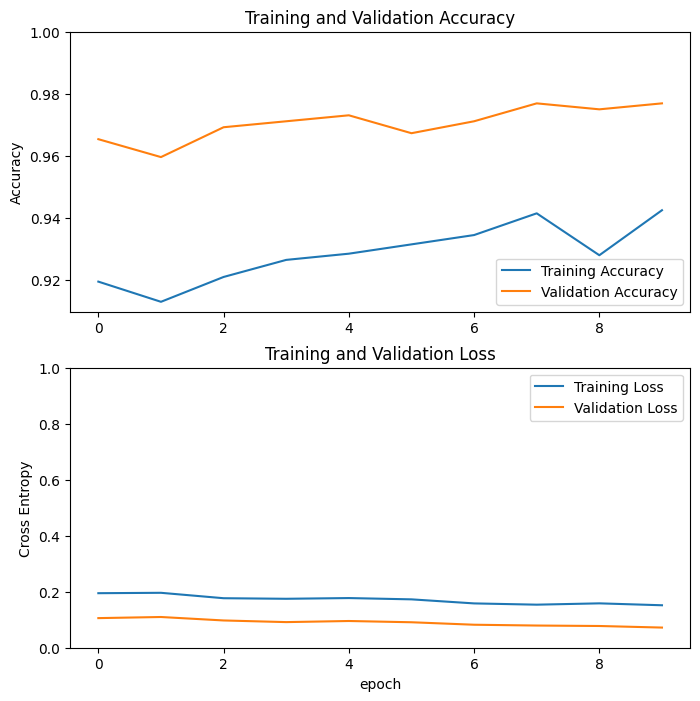

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()